In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from collections import namedtuple

%matplotlib inline

Suppose we are dealing with some stairs defined by:

In [17]:
stair_width = 30
stair_height = 10

Let's plot them:

In [18]:
def gen_stair_data(x, y, num_climbs=1):
    xs = []
    ys = []
    for i in range(num_climbs):
        xs += [x, x+stair_width]
        ys += [y, y]
        x += stair_width
        xs += [x, x]
        ys += [y, y+stair_height]
        y += stair_height
        
    return xs, ys

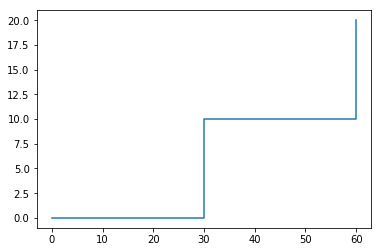

In [19]:
plt.plot(*gen_stair_data(0, 0, 2))
plt.show()

We will search for shapes parameterized by an array of radii, $r$, spanned over an angular region of size $\Delta\theta$, which is repeated for $n$ times inside a $2\pi$ region.

In [20]:
class WheelGeometry:
    def __init__(self, r, Dtheta, n):
        self.r = r
        self.Dtheta = Dtheta
        self.n = n
        
        self._cache = {}
        
    # We define some additional useful properties
    
    @property
    def theta_step(self):
        return self.Dtheta/(self.r.size - 1)
    
    @property
    def rp(self):
        return (self.r[1:] - self.r[0:-1])/self.theta_step
    
    @property
    def curve_length(self):
        return np.sum(self.chunk_lengths)
    
    @property
    def chunk_lengths(self):
        return np.sqrt(self.r[0:-1]**2 + self.r[1:]**2 - 2*np.cos(self.theta_step)*self.r[0:-1]*self.r[1:])
    
    def get_transform(self, s):
        floor_s = np.floor(s)
        
        dfirst = self._centre_trajectory_data[:, 0]
        dlast = self._centre_trajectory_data[:, -1]
        delta_translation = floor_s*(dlast[0:2] - dfirst[0:2])
        delta_rotation = floor_s*(dlast[2] - dfirst[2])
        
        num_transforms = self._centre_trajectory_data.shape[1]
        transform_index = np.floor((s - floor_s) * num_transforms)
        transform_index = int(min(num_transforms-1, transform_index))
        
        return transform2d(delta_rotation + self._centre_trajectory_data[2, transform_index], delta_translation + self._centre_trajectory_data[0:2, transform_index])
        
    @property
    def _centre_trajectory_data(self):
        try:
            return self._cache['centre_trajectory_data']
        except KeyError:
            pass
        
        g = self
        bwd_angles = compute_backward_angle(g.r[:-1], g.r[1:], g.theta_step)
        fwd_angles = compute_angle(g.r[:-1], g.r[1:], g.theta_step)

        steps = 10
        alphas = np.linspace(0, 1, steps)
        result = np.empty((3, 0), dtype=g.r.dtype)
        l = np.cumsum(g.chunk_lengths)
        rotation_angles = -(
            bwd_angles
            + g.theta_step*np.arange(g.r.size-1)
        )
        
        for i in range(g.r.size-2):
            fwd_angle = fwd_angles[i]
            bwd_angle = bwd_angles[i+1]
            
            pos_angles = np.pi - lerp(fwd_angle, bwd_angle, alphas)
            rotation_angles_interp = lerp(rotation_angles[i], rotation_angles[i+1], alphas)
            data = np.array([g.r[i+1]*np.cos(pos_angles) + l[i], g.r[i+1]*np.sin(pos_angles), rotation_angles_interp])
            result = np.concatenate((result, data), 1)
            
        self._cache['centre_trajectory_data'] = result
        return result
    
    @property
    def centre_trajectory(self):
        return self._centre_trajectory_data[0:2, :]
    
    @property
    def centre_trajectory_length(self):
        trajectory_segments = self.centre_trajectory[0:2, 1:] - self.centre_trajectory[:, :-1]
        return np.sum(np.sqrt(np.sum(trajectory_segments**2, 1)))
    
def transform2d(angle, translation):
    return np.array([
        [np.cos(angle), -np.sin(angle), translation[0]],
        [np.sin(angle), np.cos(angle), translation[1]],
        [0, 0, 1]
    ])
    
def compute_angle(r0, r1, dtheta):
    r2 = np.sqrt(r0**2 + r1**2 - 2*np.cos(dtheta)*r0*r1)
    sin_angle = np.sin(dtheta) * r0/r2
    cos_angle = (r1**2 + r2**2 - r0**2)/(2*r1*r2)
    return np.arctan2(sin_angle, cos_angle)

def compute_backward_angle(r0, r1, dtheta):
    return dtheta + compute_angle(r0, r1, dtheta)
    
def lerp(a, b, s):
    return a + (b-a)*s

We will actually pick a fixed $n=5$ for now.

We also define some utility functions that will allow us to switch between `WheelGeometry` instances and an array representation with the fixed n.

In [21]:
n = 5

def array_to_wheel_geometry(array):
    return WheelGeometry(array[:-1], array[-1], n)

def make_array_geometry(r, Dtheta):
    return np.append(r, Dtheta)

def takes_array_geometry(func):
    def decorated_func(array_or_geometry, *args, **kwargs):
        if type(array_or_geometry) is np.ndarray:
            return func(array_to_wheel_geometry(array_or_geometry), *args, **kwargs)
        elif type(array_or_geometry) is WheelGeometry:
            return func(array_or_geometry, *args, **kwargs)
        else:
            raise TypeError("Expected array or WheelGeometry. Got instead {}".format(type(array_or_geometry)))
    return decorated_func

For example, a wheel defined by $r = ({1.1}^0, {1.1}^1, \dots, {1.1}^{10}), \Delta\theta=\pi/6, n=3$ would look like this:

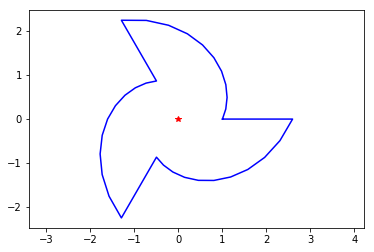

In [22]:
@takes_array_geometry
def create_wheel_plot_data(g, *args, **kwargs):
    if 'transform' in kwargs:
        transform = kwargs['transform']
    else:
        transform = np.eye(3)
        
    xx, yy = [], []
    thetas_one_segm = np.linspace(0, g.Dtheta, g.r.size)
    for i in range(g.n):
        thetas = thetas_one_segm + i*2*np.pi/g.n
        x = g.r*np.cos(thetas)
        y = g.r*np.sin(thetas)
        
        joined = np.concatenate(([x], [y], np.ones((1, x.size))))
        transformed = transform.dot(joined)
    
        x = transformed[0, :]
        y = transformed[1, :]

        xx.append(x)
        yy.append(y)

    x = np.concatenate(xx)
    x = np.append(x, x[0])
    y = np.concatenate(yy)
    y = np.append(y, y[0])
    
    return {'contour': (x, y), 'centre': ([transform[0, 2]], [transform[1, 2]]) }

@takes_array_geometry
def plot_wheel(g, *args, **kwargs):
    if not args:
        args = ('b',)
    
    plot_data = create_wheel_plot_data(g, *args, **kwargs)
    
    p0 = plt.plot(*plot_data['contour'], *args)
    p1 = plt.plot(*plot_data['centre'], 'r*')
    
    return p0 + p1

plot_wheel(WheelGeometry(1.1**(np.linspace(0, 10, 11)), 2*np.pi/3, 3))
plt.axis('equal')
plt.show()

We want to search for shapes that satisfy a couple of constraints.
We pose this in the usual way, where a function of our input must be zero, $C(g) = 0$.
Here's the code for the function $C$:

In [23]:
@takes_array_geometry
def zero_constraints(g):
    alpha_0 = compute_backward_angle(g.r[0], g.r[1], g.theta_step)
    alpha_1 = compute_angle(g.r[-2], g.r[-1], g.theta_step)

    Dalpha = alpha_1 - alpha_0
    c0 = g.curve_length - np.cos(alpha_1)*g.r[-1] + np.cos(alpha_0)*g.r[0] - stair_width
    c1 = g.r[-1]*np.sin(alpha_1) - g.r[0]*np.sin(alpha_0) - stair_height

    c2 = g.Dtheta + Dalpha - 2*np.pi/g.n

    return np.array([c0, c1, c2])

There are also a couple of inequality constraints:

In [24]:
@takes_array_geometry
def inequality_constraints(g):
    curve_length_constraint = stair_width*0.6 - g.curve_length
    
    c = np.cos(g.theta_step)
    s = np.sin(g.theta_step)
    c2 = np.cos(2*g.theta_step)
    s2 = np.sin(2*g.theta_step)

    r = g.r

    curve_is_convex_constraints = r[:-2]*(s*r[1:-1] - s2*r[2:]) + r[1:-1]*r[2:]*(c*s2 - c2*s)
    return np.append(curve_is_convex_constraints, curve_length_constraint)

To properly determine the shape, we will pose an optimization criterion on the curve.
The criterion will be formulated in terms of the trajectory of the centre when rolling on the stairs surface.
We will optimize the length of this trajectory as the wheel rolls along one of its curved segments.

In [25]:
@takes_array_geometry
def get_trajectory_length(g):
    return g.centre_trajectory_length

We now pick an initial point:

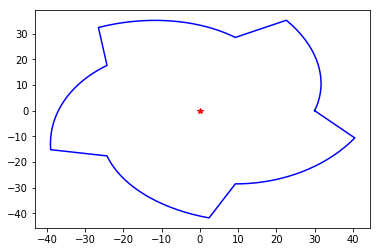

In [26]:
x0 = make_array_geometry(stair_width*np.exp(stair_height/stair_width * np.linspace(0, 1, 20)), 1)
plot_wheel(x0)
plt.show()

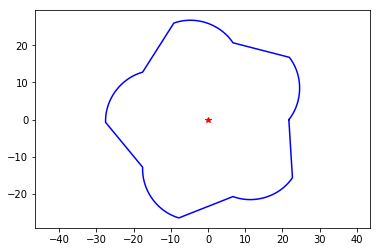

In [27]:
eq_constr = {'type': 'eq', 'fun': zero_constraints}
ineq_constr = {'type': 'ineq', 'fun': inequality_constraints}
bounds_constr = optimize.Bounds(0.1, np.append(np.repeat(100, x0.size - 1), 2*np.pi/n))

opt_res = optimize.minimize(get_trajectory_length, x0, bounds=bounds_constr, constraints=(eq_constr, ineq_constr))
g_result = array_to_wheel_geometry(opt_res.x)
plot_wheel(g_result)
plt.axis('equal')
plt.show()

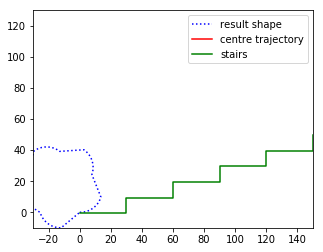

In [28]:
from matplotlib import animation, rc
from IPython.display import HTML
import base64

        
fig, ax = plt.subplots()
ax.set_xlim(-stair_width, stair_width*n)
ax.set_ylim(-stair_height, 2*stair_height*n+30)
ax.set_aspect('equal')

lines = (ax.plot([], [], 'b:', label='result shape')[0], ax.plot([], [], 'r-', label="centre trajectory")[0], ax.plot(*gen_stair_data(0, -0.5, n), 'g', label="stairs"))

ax.legend()
frame_count = n*20
def animate(frame):
    data = create_wheel_plot_data(g_result, transform=g_result.get_transform(n*frame/frame_count))
    lines[0].set_data(*data['contour'])
    
    cum_data = (create_wheel_plot_data(g_result, transform=g_result.get_transform(n*f/frame_count)) for f in range(frame+1))
    centre_data = list(zip(*((d['centre'][0][0], d['centre'][1][0]) for d in cum_data)))
    lines[1].set_data(centre_data)
    return lines

anim = animation.FuncAnimation(fig, animate, frames=frame_count, interval=50)
HTML(anim.to_jshtml())

In [30]:
anim.save('sample_result.gif', dpi=150,writer='imagemagick')

### Now let us export a document that will allow us to manufacture this

In [90]:
#### import svgwrite
import math

def cm(num):
    if type(num) is tuple:
        return tuple(cm(x) for x in num)
    return str(num) + "cm"

d = svgwrite.Drawing(filename="result.svg", width="21cm", height="29.7cm")

# draw support for splitting an angle in n pieces, where n is the n in our geometry definition
support = d.add(d.g(stroke_width="1mm", stroke="black"))
n = 5
r = 6
c_x = r + 1
c_y = r + 1

line = d.line

def add_x(d, point, size=0.5):
    d.add(line((cm(point[0] - size), cm(point[1] - size)), (cm(point[0] + size), cm(point[1] + size))))
    d.add(line((cm(point[0] - size), cm(point[1] + size)), (cm(point[0] + size), cm(point[1] - size))))
    
add_x(support, (c_x, c_y))
for i in range(n):
    add_x(support, (c_x + math.cos(i*2*math.pi/n)*r, c_y + math.sin(i*2*math.pi/n)*r))
    
support.add(d.rect(cm((0, 0)), cm((21, 29.7)), fill_opacity=0))
def draw_curve(drawing, geometry, tx, ty, phi):
    cos_phi = math.cos(phi)
    sin_phi = math.sin(phi)
    def transform(p):
        return (tx + cos_phi * p[0] - sin_phi * p[1], ty + sin_phi * p[0] + cos_phi * p[1])
    def line(x0, y0, x1, y1):
        p0 = transform((x0, y0))
        p1 = transform((x1, y1))
        return d.line(cm(p0), cm(p1))
    s = 0.90
    drawing.add(line(s*geometry.r[0], 0, (2-s)*geometry.r[0], 0))
    drawing.add(line(s*geometry.r[-1]*math.cos(geometry.Dtheta), s*geometry.r[-1]*math.sin(geometry.Dtheta), (2-s)*geometry.r[-1]*math.cos(geometry.Dtheta), (2-s)*geometry.r[-1]*math.sin(geometry.Dtheta)))
    
    thetas = np.linspace(0, geometry.Dtheta, len(geometry.r))
    for i in range(len(thetas) - 1):
        drawing.add(line(geometry.r[i]*math.cos(thetas[i]), geometry.r[i]*math.sin(thetas[i]), geometry.r[i+1]*math.cos(thetas[i+1]), geometry.r[i+1]*math.sin(thetas[i+1])))
    
draw_curve(support, g_result, 1, 40, 3*math.pi/2)


draw_curve(support, g_result, 1, 47.5, 3*math.pi/2)
    
d.save()

('21cm', '29cm')
